# **차량 파손 데이터셋**

In [8]:
!unzip -q ./damage.zip

In [2]:
!pip install -q ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.1 MB/s eta 0:00:00


In [46]:
import os
import random
import shutil
import cv2
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import ultralytics
from tqdm import tqdm
from pycocotools import mask as maskUtils

In [48]:
train_root = f'./train'
valid_root = f'./valid'
test_root = f'./test'
cls_list = ['Scratched', 'Crushed', 'Breakage', 'Separated']

In [49]:
for folder in [train_root, valid_root, test_root]:
    if not os.path.exists(folder):
        os.makedirs(folder)
    for s in ['images', 'labels']:
        s_folder = f'{folder}/{s}'
        if not os.path.exists(s_folder):
            os.makedirs(s_folder)

In [50]:
data_list = glob.glob('/content/원천데이터/TS_damage/damage/*.jpg')
len(data_list)

1200

In [51]:
data_list[0]

'/content/원천데이터/TS_damage/damage/0075526_as-2570026.jpg'

In [52]:
def draw_polygon_by_index(idx):
    image_path = data_list[idx]
    image = cv2.imread(image_path)
    json_path = image_path.replace('원천데이터', '라벨링데이터').replace('TS_damage', 'TL_damage').replace('.jpg', '.json')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    with open(json_path, 'r') as f:
        data = json.load(f)

    for ann in data['annotations']:
        if 'segmentation' in ann:
            segmentation = ann['segmentation']
            if isinstance(segmentation, list):
                for seg in segmentation:
                    if isinstance(seg, list):
                        points = np.array(seg).reshape(-1, 2).astype(np.int32)
                        cv2.polylines(image, [points], isClosed=True, color=(255, 0, 0), thickness=2)

    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Polygon Overlay: {os.path.basename(image_path)}')
    plt.show()

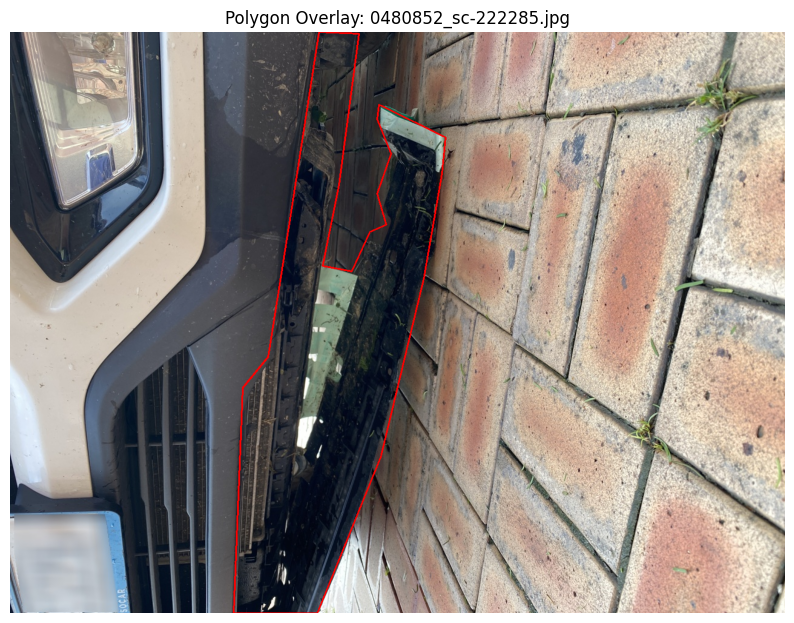

In [53]:
draw_polygon_by_index(10)

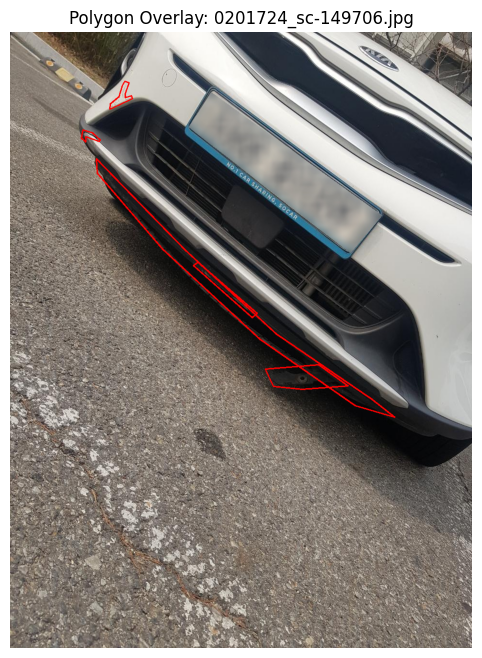

In [54]:
draw_polygon_by_index(15)

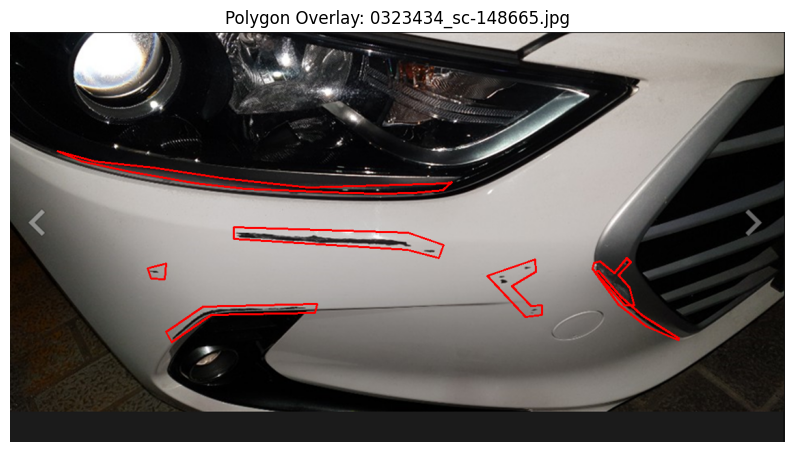

In [55]:
draw_polygon_by_index(20)

In [56]:
damage_classes = {
    "Scratched": 0,
    "Crushed": 1,
    "Breakage": 2,
    "Separated": 3
}

In [57]:
def convert_json_to_yolo(json_path, save_dir):
    with open(json_path, 'r') as f:
        data = json.load(f)

    image_info = data['images']
    img_width, img_height = image_info['width'], image_info['height']

    yolo_annotations = []

    for ann in data['annotations']:
        if 'segmentation' in ann and 'damage' in ann:
            segmentation = ann['segmentation'][0][0]

            if isinstance(segmentation[0], list):
                segmentation = [coord for sublist in segmentation for coord in sublist]

            normalized_coords = [segmentation[i] / img_width if i % 2 == 0 else segmentation[i] / img_height for i in range(len(segmentation))]

            class_label = damage_classes.get(ann['damage'], -1)
            yolo_annotations.append(f'{class_label} ' + ' '.join(map(str, normalized_coords)))

    yolo_filename = os.path.basename(json_path).replace('.json', '.txt')
    save_path = os.path.join(save_dir, yolo_filename)

    with open(save_path, 'w') as f:
        f.write('\n'.join(yolo_annotations))

In [58]:
for json_path in tqdm(glob.glob(os.path.join('/content/라벨링데이터/TL_damage/damage', '*.json'))):
    if not os.path.exists('./label'):
        os.makedirs('./label')
    convert_json_to_yolo(json_path, './label')

print(f'YOLO 형식 변환 완료!!')

100%|██████████| 1200/1200 [00:00<00:00, 1607.28it/s]

YOLO 형식 변환 완료!!


In [59]:
random.seed(2025)
file_list = glob.glob('./label/*.txt')

random.shuffle(file_list)
test_ratio = 0.1
num_file = len(file_list)
num_file

1200

In [60]:
test_list = file_list[:int(num_file*test_ratio)]
valid_list = file_list[int(num_file*test_ratio):int(num_file*test_ratio)*2]
train_list = file_list[int(num_file*test_ratio)*2:]

len(test_list), len(valid_list), len(train_list)

(120, 120, 960)

In [62]:
# './label/0051632_sc-164684.txt'
test_list

['./label/0034393_as-0100039.txt',
 './label/0427203_sc-159085.txt',
 './label/0034391_as-0100039.txt',
 './label/0015899_sc-1025464.txt',
 './label/0268550_as-0097762.txt',
 './label/0386212_as-2801540.txt',
 './label/0133270_sc-156226.txt',
 './label/0482981_sc-162622.txt',
 './label/0099823_as-7336887.txt',
 './label/0493920_sc-203041.txt',
 './label/0235794_sc-163780.txt',
 './label/0425714_as-7231162.txt',
 './label/0287136_as-7925313.txt',
 './label/0431984_sc-160942.txt',
 './label/0102626_sc-204032.txt',
 './label/0498700_as-0098334.txt',
 './label/0357378_as-2876849.txt',
 './label/0470361_sc-145728.txt',
 './label/0068851_sc-170115.txt',
 './label/0447353_as-7029542.txt',
 './label/0125390_as-7509711.txt',
 './label/0421739_sc-153008.txt',
 './label/0422101_as-0100120.txt',
 './label/0433232_sc-159787.txt',
 './label/0079838_as-3060976.txt',
 './label/0489884_as-3044828.txt',
 './label/0455603_sc-128227.txt',
 './label/0305353_sc-157275.txt',
 './label/0492573_sc-194429.txt',

In [63]:
for i in tqdm(train_list):
    label_name = i.split('/')[-1]
    shutil.copyfile(i, f'{train_root}/labels/{label_name}')
    img_name = i.split('/')[-1].replace('txt', 'jpg')
    img_path = f'/content/원천데이터/TS_damage/damage/{img_name}'
    shutil.copyfile(img_path, f'{train_root}/images/{img_name}')

100%|██████████| 960/960 [00:08<00:00, 118.56it/s]


In [64]:
for i in tqdm(test_list):
    label_name = i.split('/')[-1]
    shutil.copyfile(i, f'{test_root}/labels/{label_name}')
    img_name = i.split('/')[-1].replace('txt', 'jpg')
    img_path = f'/content/원천데이터/TS_damage/damage/{img_name}'
    shutil.copyfile(img_path, f'{test_root}/images/{img_name}')

100%|██████████| 120/120 [00:00<00:00, 282.73it/s]


In [65]:
for i in tqdm(valid_list):
    label_name = i.split('/')[-1]
    shutil.copyfile(i, f'{valid_root}/labels/{label_name}')
    img_name = i.split('/')[-1].replace('txt', 'jpg')
    img_path = f'/content/원천데이터/TS_damage/damage/{img_name}'
    shutil.copyfile(img_path, f'{valid_root}/images/{img_name}')

100%|██████████| 120/120 [00:00<00:00, 185.60it/s]


In [66]:
import yaml

data = dict()

data['train'] = train_root
data['val'] = valid_root
data['test'] = test_root
data['nc'] = len(cls_list)
data['names'] = cls_list

with open(f'car_damage.yaml', 'w') as f:
    yaml.dump(data, f)

In [67]:
from ultralytics import YOLO

In [68]:
# 모델, 네트워크 구조와 하이퍼파라미터를 정의한 YAML 파일을 pt 파일로 변경
# 빈 구조에서 시작하므로 수렴 느림/최고성능 낮음.
# model = YOLO('yolov8s-seg.yaml')
model = YOLO('yolov8m-seg.pt')

In [19]:
# results = model.train(
#     data = 'car_damage.yaml',
#     epochs = 100,
#     imgsz = 224,
#     batch = 16,
#     device = 0,
#     name = 'damage_s'
# )

results = model.train(
    data='car_damage.yaml',
    epochs=100,
    imgsz=960,           # 224 → 960 이미지 사이즈를 키우면 미세 흠집까지 감지
    batch=-1,            # auto
    optimizer='SGD',
    lr0=0.003, lrf=0.15, cos_lr=True,
    warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1,
    weight_decay=0.0005, momentum=0.937,

    # 증강 (미세 파손 경계 보존)
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
    degrees=0.0, translate=0.08, scale=0.85, shear=2.0,
    perspective=0.0005,
    fliplr=0.5, flipud=0.1,
    mosaic=0.5, mixup=0.05, copy_paste=0.1,
    close_mosaic=10,     # 마지막 10 epoch은 mosaic off로 수렴 안정

    # 안정성/로그
    patience=40,
    seed=2025,
    deterministic=True,
    amp=True,
    rect=False,
    cache='ram',
    workers=2,

    device = 0,
    name = 'damage_s'
)

Ultralytics 8.3.198 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=car_damage.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.003, lrf=0.15, mask_ratio=4, max_det=300, mixup=0.05, mode=train, model=runs/segment/damage_s5/weights/best.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=damage_s6, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=40, perspective=0.0005, p

In [5]:
# ➊ model 준비: 마지막 학습의 best.pt가 있으면 그걸로, 없으면 사전학습 가중치로
from ultralytics import YOLO
from pathlib import Path
import os

best = None

# A. 직전 학습 셀의 results가 있고, 그 안에 save_dir가 있으면 우선 사용
if 'results' in globals():
    sd = Path(getattr(results, 'save_dir', ''))
    if sd.exists():
        cand = sd / 'weights' / 'best.pt'
        if cand.exists():
            best = cand

# B. 없으면 runs/**/weights/best.pt 중 최신 것을 사용
if best is None:
    cands = sorted(Path('runs').rglob('weights/best.pt'), key=os.path.getmtime)
    if cands:
        best = cands[-1]

# C. 그래도 없으면 사전학습 가중치(평가만 해볼 때)
model = YOLO(str(best)) if best is not None else YOLO('yolov8m-seg.pt')
print("Using weights:", str(best) if best else 'yolov8m-seg.pt')


Using weights: runs/segment/damage_s5/weights/best.pt


In [7]:
# results = model.val(
#     source='./val',
#     imgsz=224,
#     conf= 0.30,
#     device=0,
#     save=True,
#     save_conf=True
# )

results = model.val(
    source='./test', # 테스트 데이터셋 경로로 변경
    imgsz=960,        # train과 동일 해상도(이전 224 → 960)
    conf=0.001,       # 평가에서 과도 필터링 방지 (PR 곡선/정확한 mAP 산출)
    iou=0.7,          # NMS IoU(기본과 유사; 과탐 억제)
    device=0,
    batch=8,          # 자동 배치가 아닌 양의 정수 값 사용 -> 메모리 부족 해결 시도
    workers=2,
    half=True,        # FP16 (지원 GPU일 때)
    plots=True,       # PR/F1/혼동행렬 등 자동 저장
    save=True,        # 시각화된 결과 이미지 저장
    # save_conf=True,   예측 신뢰도 저장(버전 호환되면 유지)
    save_json=True    # COCO json 저장(리더보드/후분석 용이)
)

Ultralytics 8.3.198 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 96.7±27.4 MB/s, size: 549.3 KB)
val: Scanning /content/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 120/120 243.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 0.0it/s 7:36
                   all        120        435      0.166      0.089      0.067     0.0286     0.0937     0.0409     0.0299     0.0117
             Scratched        109        304      0.153      0.158     0.0758     0.0277      0.131      0.105     0.0471     0.0132
               Crushed         25         29          0          0      0.007    0.00191          0          0          0          0
              Breakage         37         53       0.29     0.0943      0.103       0.06      0.168     0.0377     0.0419     0.0269
       

In [8]:
import pandas as pd
from pathlib import Path

# train()의 반환 객체가 results 라고 가정 (before와 동일)
df_after = pd.DataFrame(results.summary())

# 같은 폴더에 파일명만 다르게
out_csv = Path('runs/damage_s3/val_metrics_after.csv')
out_csv.parent.mkdir(parents=True, exist_ok=True)
df_after.to_csv(out_csv, index=False)

print("✅ CSV 저장 완료:", out_csv)
print(df_after.tail())

✅ CSV 저장 완료: runs/damage_s3/val_metrics_after.csv
       Class  Images  Instances    Box-P    Box-R   Box-F1    mAP50  mAP50-95  \
0  Scratched     109        304  0.15287  0.15789  0.15534  0.07584   0.02774   
1    Crushed      25         29  0.00000  0.00000  0.00000  0.00700   0.00191   
2   Breakage      37         53  0.29022  0.09434  0.14239  0.10315   0.05997   
3  Separated      36         49  0.22027  0.10384  0.14114  0.08191   0.02465   

    Mask-P   Mask-R  Mask-F1  
0  0.13121  0.10526  0.11681  
1  0.00000  0.00000  0.00000  
2  0.16804  0.03774  0.06163  
3  0.07560  0.02041  0.03214  


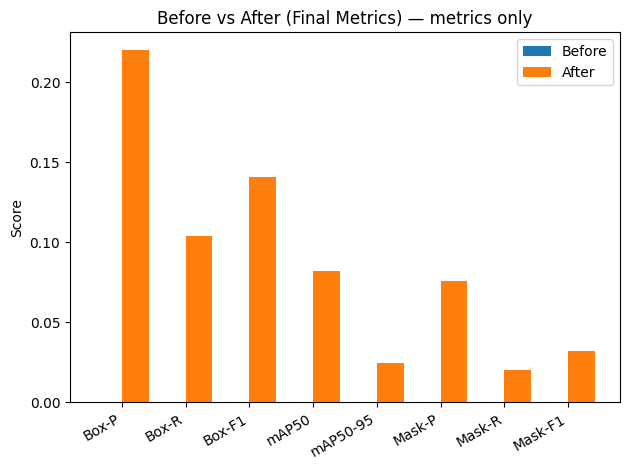

📊 Saved: runs/damage_s3/before_vs_after_metrics_only.png


In [14]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# CSV 경로
b_path = Path('runs/damage_s3/val_metrics.csv')          # before
a_path = Path('runs/damage_s3/val_metrics_after.csv')    # after

df_b = pd.read_csv(b_path)
df_a = pd.read_csv(a_path)
row_b, row_a = df_b.iloc[-1], df_a.iloc[-1]

# 공통 컬럼 중 숫자형이면서 Images/Instances는 제외
exclude = {'images', 'instances'}
common = [c for c in row_b.index if c in row_a.index]
def is_num(v):
    try:
        float(v); return True
    except Exception:
        return False

cols = [c for c in common
        if c.lower() not in exclude and is_num(row_b[c]) and is_num(row_a[c])]

# metrics/* 우선(있으면 앞으로), 나머지는 뒤에
metrics_first = [c for c in cols if c.startswith('metrics/')]
others = [c for c in cols if c not in metrics_first]
cols = metrics_first + others

# 막대그래프 (Images/Instances 제거됨)
idx = np.arange(len(cols)); w = 0.42
plt.figure()
plt.bar(idx - w/2, [float(row_b[c]) for c in cols], w, label='Before')
plt.bar(idx + w/2, [float(row_a[c]) for c in cols], w, label='After')
plt.xticks(idx, cols, rotation=30, ha='right')
plt.ylabel('Score')
plt.title('Before vs After (Final Metrics) — metrics only')
plt.legend()
plt.tight_layout()
plt.savefig('runs/damage_s3/before_vs_after_metrics_only.png', dpi=200)
plt.show()
print('📊 Saved: runs/damage_s3/before_vs_after_metrics_only.png')


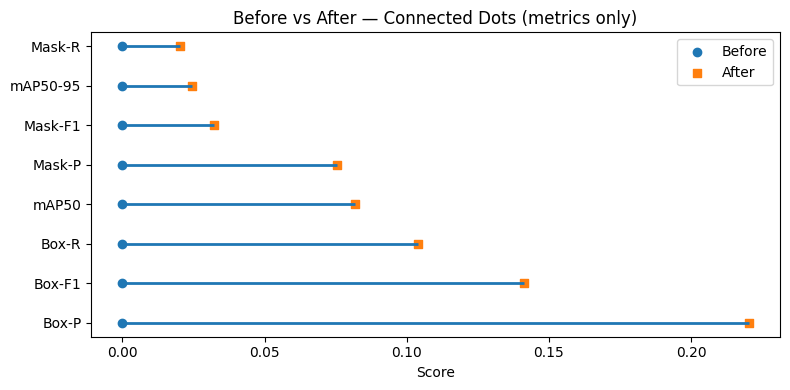

In [17]:
# === 덤벨 차트: Before/After를 명확히 구분 (색 미지정, 마커/범례만) ===
import matplotlib.pyplot as plt
import numpy as np

# b_plot, a_plot, order, use_log, eps 는 앞 셀에서 계산된 그대로 사용한다고 가정
y = np.arange(len(order))
plt.figure(figsize=(8, max(4, 0.5*len(order))))

# 연결선(왼쪽=작은 값, 오른쪽=큰 값)
for yi, xb, xa in zip(y, b_plot, a_plot):
    plt.hlines(yi, xb, xa, linewidth=2)

# 점을 따로 찍고 범례 부여
plt.scatter(b_plot, y, marker='o', label='Before')
plt.scatter(a_plot, y, marker='s', label='After')

plt.yticks(y, order)
plt.xlabel('Score')
plt.title('Before vs After — Connected Dots (metrics only)')
if use_log: plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()
